In [1]:
import pandas as pd
# load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
# grab time series of electricity usage
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['electricity_usage'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['date_time', 'electricity_usage']].copy()
# set the index as and sort by date and time
df = df.set_index('date_time').sort_index()
# resample to hourly frequency
df_hour = df.resample('1H').mean()
# create shifted time series
df_hour['electricity_usage'] = df_hour['electricity_usage'].fillna(method='ffill')
df_hour['electricity_usage_1hr_lag'] = df_hour['electricity_usage'].shift()
df_hour['electricity_usage_2hr_lag'] = df_hour['electricity_usage'].shift(2)
df_hour['electricity_usage_3hr_lag'] = df_hour['electricity_usage'].shift(3)
df_hour['electricity_usage_4hr_lag'] = df_hour['electricity_usage'].shift(4)
df_hour['electricity_usage_5hr_lag'] = df_hour['electricity_usage'].shift(5)
df_hour['electricity_usage_6hr_lag'] = df_hour['electricity_usage'].shift(6)
df_hour['electricity_usage_7hr_lag'] = df_hour['electricity_usage'].shift(7)
df_hour['electricity_usage_8hr_lag'] = df_hour['electricity_usage'].shift(8)
# create month/seasonality as a feature
df_hour['month'] = df_hour.index.month
# drop missing data
df_hour = df_hour.dropna()
# split train test sets
sample_size = df_hour.shape[0] - 200
df_train = df_hour.iloc[:sample_size].copy()
df_test = df_hour.iloc[sample_size:].copy()

In [2]:
df_train.head()

,electricity_usage,electricity_usage_1hr_lag,electricity_usage_2hr_lag,electricity_usage_3hr_lag,electricity_usage_4hr_lag,electricity_usage_5hr_lag,electricity_usage_6hr_lag,electricity_usage_7hr_lag,electricity_usage_8hr_lag,month
date_time,,,,,,,,,,
2006-12-17 01:00:00,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,3.632200,4.222889,12
2006-12-17 02:00:00,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,3.632200,12
2006-12-17 03:00:00,1.662200,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,12
2006-12-17 04:00:00,2.215767,1.662200,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,12
2006-12-17 05:00:00,1.996733,2.215767,1.662200,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,12


In [3]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 17.0.1+12-39, mixed mode, sharing)
  Starting server from C:\Users\liann\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\liann\AppData\Local\Temp\tmpxse1nup8
  JVM stdout: C:\Users\liann\AppData\Local\Temp\tmpxse1nup8\h2o_liann_started_from_python.out
  JVM stderr: C:\Users\liann\AppData\Local\Temp\tmpxse1nup8\h2o_liann_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_liann_qlcztz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.930 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [4]:
h2o_frame = h2o.H2OFrame(df_train)
x = h2o_frame.columns
y = 'electricity_usage'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
h2o_automl = H2OAutoML(sort_metric='mse', max_runtime_secs=5*60, seed=666)
h2o_automl.train(x=x, y=y, training_frame=h2o_frame)

AutoML progress: |
19:31:24.283: AutoML: XGBoost is not available; skipping it.
19:31:24.307: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:31:24.307: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20220328_193124

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.2518938608005659
RMSE: 0.5018902876133049
MAE: 0.345779439169894
RMSLE: 0.21113076473461628
R^2: 0.6728471203228965
Mean Residual Deviance: 0.2518938608005659
Null degrees of freedom: 10047
Residual degrees of freedom: 10033
Null deviance: 7737.841923940112
Residual deviance: 2531.029513324086
AIC: 14693.334209897977

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0

In [6]:
h2o_models = h2o.automl.get_leaderboard(h2o_automl, extra_columns = "ALL")
h2o_models

model_id,mse,mean_residual_deviance,rmse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_3_AutoML_1_20220328_193124,0.358631,0.358631,0.598858,0.408395,0.248884,993,0.035054,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20220328_193124,0.358848,0.358848,0.599039,0.40867,0.248953,503,0.020829,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20220328_193124,0.358881,0.358881,0.599067,0.409069,0.248949,395,0.017443,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20220328_193124,0.358965,0.358965,0.599137,0.409093,0.249049,447,0.018033,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20220328_193124,0.359382,0.359382,0.599485,0.409906,0.249145,302,0.014205,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220328_193124,0.360317,0.360317,0.600264,0.411528,0.249621,481,0.006144,StackedEnsemble
GBM_1_AutoML_1_20220328_193124,0.360923,0.360923,0.600769,0.412772,0.250035,1220,0.005825,GBM
GBM_2_AutoML_1_20220328_193124,0.36299,0.36299,0.602487,0.414703,0.25077,508,0.004247,GBM
GBM_5_AutoML_1_20220328_193124,0.364925,0.364925,0.60409,0.415846,0.251595,513,0.004947,GBM
GBM_3_AutoML_1_20220328_193124,0.364999,0.364999,0.604151,0.414597,0.251019,566,0.005147,GBM


In [7]:
from h2o.model.regression import h2o_mean_squared_error

h2o_frame_test = h2o.H2OFrame(df_test)

y_pred = h2o_automl.predict(h2o_frame_test)
y_actual = h2o.H2OFrame(df_test[['electricity_usage']])

h2o_mean_squared_error(y_actual, y_pred)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0.2983646709832114

<AxesSubplot:xlabel='date_time'>

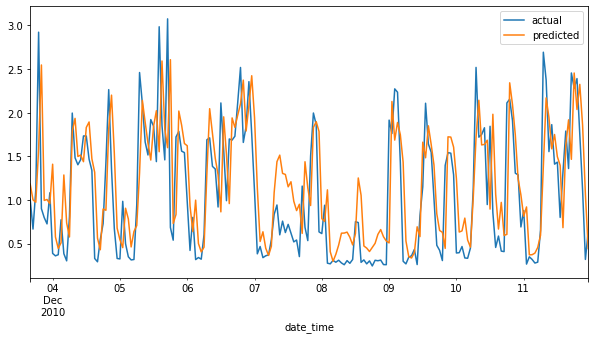

In [8]:
h2o_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred.as_data_frame().to_numpy().ravel()})
h2o_compare.plot(figsize=(10, 5))